![](UC_FMRI.jpg)

# Iterables


Algunos pasos en un análisis de neuroimagen son repetitivos. Ejecutar el mismo preprocesamiento en varios temas o realizar inferencias estadísticas en varios archivos. Para evitar la creación de múltiples scripts individuales, Nipype tiene como complemento de ejecución Workflow llamado iterables.

Supongamos que tenemos un flujo de trabajo con dos nodos, el nodo (A) realiza una extracción simple del cráneo y es seguido por un nodo (B) que realiza el suavizado isométrico. Ahora, digamos, que tenemos curiosidad sobre el efecto de diferentes núcleos suavizantes. Por lo tanto, queremos ejecutar el nodo de suavizado con FWHM configurado en 2 mm, 8 mm y 16 mm.

In [35]:
%pwd

'/opt/home/aracena/thesis_practica/tips_nipype/iterables'

# Definimos parametros

In [24]:
# Ruta del directorio donde reposan las imagenes
dir_exp = '/home/aracena/thesis_practica/data/ds002422/sub-01/anat/'

# Imagen
img_ana = 'sub-01_T1w.nii'

# Ruta Imagen
dir_img_ana = dir_exp + img_ana

# Ruta donde se guarda las imgenes procesadas
dir_res_pro = '/home/aracena/thesis_practica/tips_nipype/iterables/output/'

In [25]:
from nipype import Node, Workflow
from nipype.interfaces.fsl import BET, IsotropicSmooth

In [26]:
##----- Creamos los nodos------

# Initiate a skull stripping Node with BET
skullstrip = Node(BET(mask=True,
                      in_file=dir_img_ana),
                  name="skullstrip")

isosmooth = Node(IsotropicSmooth(), name='iso_smooth')

Ahora, usar iterables y, por lo tanto, suavizar con diferentes fwhm es tan simple como eso:

In [27]:
isosmooth.iterables = ("fwhm", [4, 8, 16])

Necesitamos crear un flujo de trabajo, conectar los nodos y, finalmente, podemos ejecutar el flujo de trabajo en paralelo.

In [28]:
# Create the workflow
wf = Workflow(name="smoothflow")
wf.base_dir = dir_res_pro
wf.connect(skullstrip, 'out_file', isosmooth, 'in_file')

# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 3})

211222-01:41:27,852 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
211222-01:41:27,865 nipype.workflow INFO:
	 Running in parallel.
211222-01:41:27,872 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.99/13.99, Free processors: 3/3.
211222-01:41:28,9 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/opt/home/aracena/thesis_practica/tips_nipype/iterables/output/smoothflow/skullstrip".
211222-01:41:28,15 nipype.workflow INFO:
	 [Node] Executing "skullstrip" <nipype.interfaces.fsl.preprocess.BET>
211222-01:41:29,873 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.79/13.99, Free processors: 2/3.
                     Currently running:
                       * smoothflow.skullstrip
211222-01:41:33,977 nipype.workflow INFO:
	 [Node] Finished "skullstrip", elapsed time 5.960263s.
211222-01:41:35,877 nipype.workflow INFO:
	 [Job 0] C

Si visualizamos el gráfico con exec, podemos ver dónde tiene lugar realmente la paralelización.


211222-01:41:53,587 nipype.workflow INFO:
	 Generated workflow graph: /home/aracena/thesis_practica/tips_nipype/iterables/output/smoothflow/graph.png (graph2use=exec, simple_form=True).


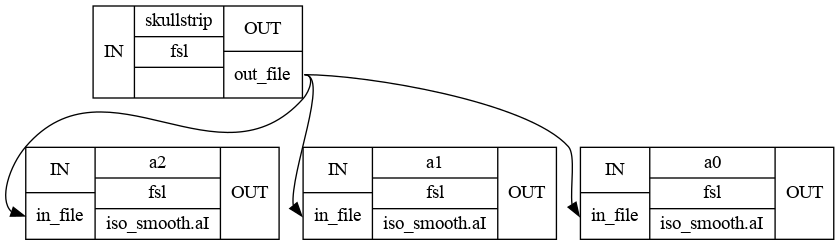

In [29]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)
Image(filename=dir_res_pro+'smoothflow/graph_detailed.png')

Visualizamos resultados

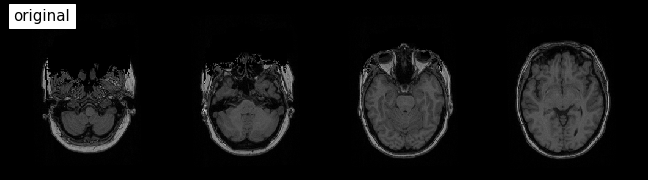

In [30]:
from nilearn import plotting
%matplotlib inline

plotting.plot_anat(dir_img_ana, title='original',
    display_mode='z', dim=-1, cut_coords=(-50, -35, -20, -5), annotate=False);

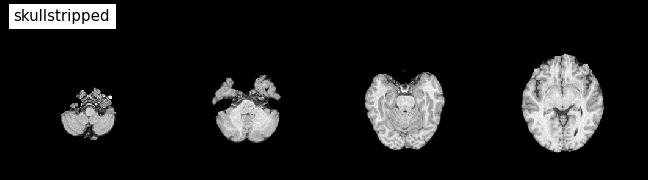

In [31]:
plotting.plot_anat(dir_res_pro +
    'smoothflow/skullstrip/sub-01_T1w_brain.nii.gz', title='skullstripped',
    display_mode='z', dim=-1, cut_coords=(-50, -35, -20, -5), annotate=False);

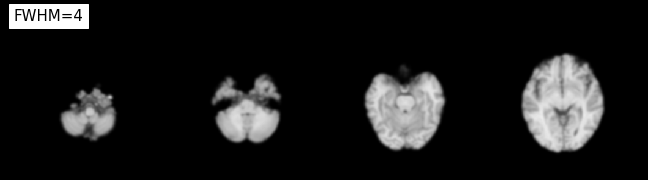

In [32]:
plotting.plot_anat(dir_res_pro +
    'smoothflow/_fwhm_4/iso_smooth/sub-01_T1w_brain_smooth.nii.gz', title='FWHM=4',
    display_mode='z', dim=-0.5, cut_coords=(-50, -35, -20, -5), annotate=False);

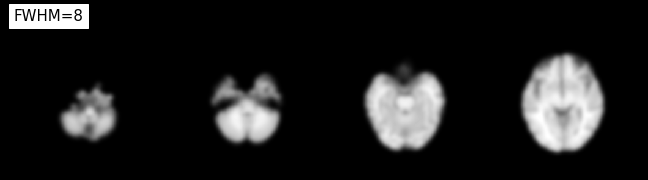

In [33]:
plotting.plot_anat(dir_res_pro +
    'smoothflow/_fwhm_8/iso_smooth/sub-01_T1w_brain_smooth.nii.gz', title='FWHM=8',
    display_mode='z', dim=-0.5, cut_coords=(-50, -35, -20, -5), annotate=False);

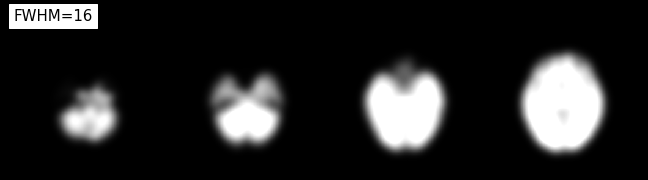

In [34]:
plotting.plot_anat(dir_res_pro +
    'smoothflow/_fwhm_16/iso_smooth/sub-01_T1w_brain_smooth.nii.gz', title='FWHM=16',
    display_mode='z', dim=-0.5, cut_coords=(-50, -35, -20, -5), annotate=False);

# FIN